In [2]:
import pandas as pd
import numpy as np
import re

import statsmodels.api as sm

from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

## Data Prepare

In [3]:
spret = pd.read_csv('/Users/msstark/Desktop/Brandeis/Field Project/code/spReturn.csv').drop('Unnamed: 0',axis = 1)
bcom  = pd.read_csv('/Users/msstark/Desktop/Brandeis/Field Project/code/bcomSelect.csv').drop('Unnamed: 0',axis = 1)
cpi   = pd.read_csv('/Users/msstark/Desktop/Brandeis/Field Project/code/cpiSelect.csv').drop('Unnamed: 0',axis = 1)
pmi   = pd.read_csv('/Users/msstark/Desktop/Brandeis/Field Project/code/pmiSelect2.csv').drop('Unnamed: 0',axis = 1)
dxy   = pd.read_csv('/Users/msstark/Desktop/Brandeis/Field Project/code/dxySelect.csv').drop('Unnamed: 0',axis = 1)


In [4]:
spret.head()

,Date,Materials_ret,_Industrials_ret,_Consumer_Discretionary_ret,Consumer_Staples_ret,_Health_Care_ret,Financials_ret,Information_Technology_ret,Telecommunication_Services__ret,Utilities_ret,Real_Estate_ret,Energy_ret
0,1995-02-01,0.064244,0.052688,0.033880,0.028613,0.011563,0.052696,0.066760,0.005734,0.000942,-0.011090,0.031235
1,1995-03-01,0.053224,0.033088,0.030175,0.028865,0.027695,0.001254,0.050385,0.002281,-0.022580,-0.006164,0.050957
2,1995-04-01,0.012541,0.030675,-0.013433,0.028333,0.024959,0.033539,0.105226,0.021426,0.027722,0.036709,0.027098
3,1995-05-01,0.029633,0.021884,0.044629,0.043040,0.022940,0.074939,0.037986,-0.007054,0.065561,0.014088,0.029913
4,1995-06-01,0.036621,0.015762,0.026340,0.016143,0.041401,0.003703,0.090244,0.027482,-0.015030,0.007169,-0.036326


In [5]:
spret.shape

(328, 12)

In [6]:
df = bcom.iloc[:,[0,-2]].copy()
df['cpi_ret'] = cpi.iloc[:,-2].copy()
df['pmi_ret'] = pmi.iloc[:,-1].copy()
df['dxy_ret'] = dxy.iloc[:,-2].copy()
df.head()

,Date,bcom_ret,cpi_ret,pmi_ret,dxy_ret
0,1994-12-31,0.023380,0.002003,0.023173,-0.004376
1,1995-01-31,-0.010776,0.002665,-0.040070,-0.009804
2,1995-02-28,-0.005805,0.002658,-0.054446,-0.021737
3,1995-03-31,0.019684,0.001988,-0.011516,-0.048744
4,1995-04-30,0.015482,0.003968,-0.093204,0.002079


### Lag CPI

In [7]:
df['cpi_ret'] = df['cpi_ret'].shift(1)
df.dropna(inplace = True)
df.head()

,Date,bcom_ret,cpi_ret,pmi_ret,dxy_ret
1,1995-01-31,-0.010776,0.002003,-0.040070,-0.009804
2,1995-02-28,-0.005805,0.002665,-0.054446,-0.021737
3,1995-03-31,0.019684,0.002658,-0.011516,-0.048744
4,1995-04-30,0.015482,0.001988,-0.093204,0.002079
5,1995-05-31,-0.012037,0.003968,-0.017131,0.007689


In [8]:
df.shape

(327, 5)

### Merge Independent and Dependent Variables

In [9]:
df = df.reset_index().drop('index',axis = 1).copy()
df.head()

,Date,bcom_ret,cpi_ret,pmi_ret,dxy_ret
0,1995-01-31,-0.010776,0.002003,-0.040070,-0.009804
1,1995-02-28,-0.005805,0.002665,-0.054446,-0.021737
2,1995-03-31,0.019684,0.002658,-0.011516,-0.048744
3,1995-04-30,0.015482,0.001988,-0.093204,0.002079
4,1995-05-31,-0.012037,0.003968,-0.017131,0.007689


In [10]:
df = df.merge(spret.iloc[:-1,1:],left_index = True, right_index = True).copy()
#df.set_index('Date',inplace = True)
df.head()

,Date,bcom_ret,cpi_ret,pmi_ret,dxy_ret,Materials_ret,_Industrials_ret,_Consumer_Discretionary_ret,Consumer_Staples_ret,_Health_Care_ret,Financials_ret,Information_Technology_ret,Telecommunication_Services__ret,Utilities_ret,Real_Estate_ret,Energy_ret
0,1995-01-31,-0.010776,0.002003,-0.040070,-0.009804,0.064244,0.052688,0.033880,0.028613,0.011563,0.052696,0.066760,0.005734,0.000942,-0.011090,0.031235
1,1995-02-28,-0.005805,0.002665,-0.054446,-0.021737,0.053224,0.033088,0.030175,0.028865,0.027695,0.001254,0.050385,0.002281,-0.022580,-0.006164,0.050957
2,1995-03-31,0.019684,0.002658,-0.011516,-0.048744,0.012541,0.030675,-0.013433,0.028333,0.024959,0.033539,0.105226,0.021426,0.027722,0.036709,0.027098
3,1995-04-30,0.015482,0.001988,-0.093204,0.002079,0.029633,0.021884,0.044629,0.043040,0.022940,0.074939,0.037986,-0.007054,0.065561,0.014088,0.029913
4,1995-05-31,-0.012037,0.003968,-0.017131,0.007689,0.036621,0.015762,0.026340,0.016143,0.041401,0.003703,0.090244,0.027482,-0.015030,0.007169,-0.036326


In [11]:
df.isna().sum()

Date                               0
bcom_ret                           0
cpi_ret                            0
pmi_ret                            0
dxy_ret                            0
Materials_ret                      0
_Industrials_ret                   0
_Consumer_Discretionary_ret        0
Consumer_Staples_ret               0
_Health_Care_ret                   0
Financials_ret                     0
Information_Technology_ret         0
Telecommunication_Services__ret    0
Utilities_ret                      0
Real_Estate_ret                    0
Energy_ret                         0
dtype: int64

In [12]:
#df.to_csv('FullData2.csv')

Then, we used the following three measurement to test the performance of the simple moving average forecast.

In [13]:
# function to estimate the root of mean squared error
def RMSE(yActual,yPred):
    sr  = np.square(yActual - yPred)
    msr = np.mean(sr)
    return np.sqrt(msr)

## Static Regression

In [14]:
window = 1

In [15]:
df_select = df.copy()
df_select.iloc[:,1:5] = df_select.iloc[:,1:5].shift(window)
df_select = df_select[window:].reset_index().drop('index',axis = 1)
df_select.head()

,Date,bcom_ret,cpi_ret,pmi_ret,dxy_ret,Materials_ret,_Industrials_ret,_Consumer_Discretionary_ret,Consumer_Staples_ret,_Health_Care_ret,Financials_ret,Information_Technology_ret,Telecommunication_Services__ret,Utilities_ret,Real_Estate_ret,Energy_ret
0,1995-02-28,-0.010776,0.002003,-0.040070,-0.009804,0.053224,0.033088,0.030175,0.028865,0.027695,0.001254,0.050385,0.002281,-0.022580,-0.006164,0.050957
1,1995-03-31,-0.005805,0.002665,-0.054446,-0.021737,0.012541,0.030675,-0.013433,0.028333,0.024959,0.033539,0.105226,0.021426,0.027722,0.036709,0.027098
2,1995-04-30,0.019684,0.002658,-0.011516,-0.048744,0.029633,0.021884,0.044629,0.043040,0.022940,0.074939,0.037986,-0.007054,0.065561,0.014088,0.029913
3,1995-05-31,0.015482,0.001988,-0.093204,0.002079,0.036621,0.015762,0.026340,0.016143,0.041401,0.003703,0.090244,0.027482,-0.015030,0.007169,-0.036326
4,1995-06-30,-0.012037,0.003968,-0.017131,0.007689,0.026904,0.044611,0.032983,-0.000085,0.046298,0.026708,0.061420,0.034389,-0.003391,0.007297,0.032717


In [16]:
test_size = len(df_select)//3
df_train  = df_select.iloc[:-test_size]
df_test   = df_select.iloc[-test_size:]

In [17]:
test_size

108

In [18]:
df_train.head()

,Date,bcom_ret,cpi_ret,pmi_ret,dxy_ret,Materials_ret,_Industrials_ret,_Consumer_Discretionary_ret,Consumer_Staples_ret,_Health_Care_ret,Financials_ret,Information_Technology_ret,Telecommunication_Services__ret,Utilities_ret,Real_Estate_ret,Energy_ret
0,1995-02-28,-0.010776,0.002003,-0.040070,-0.009804,0.053224,0.033088,0.030175,0.028865,0.027695,0.001254,0.050385,0.002281,-0.022580,-0.006164,0.050957
1,1995-03-31,-0.005805,0.002665,-0.054446,-0.021737,0.012541,0.030675,-0.013433,0.028333,0.024959,0.033539,0.105226,0.021426,0.027722,0.036709,0.027098
2,1995-04-30,0.019684,0.002658,-0.011516,-0.048744,0.029633,0.021884,0.044629,0.043040,0.022940,0.074939,0.037986,-0.007054,0.065561,0.014088,0.029913
3,1995-05-31,0.015482,0.001988,-0.093204,0.002079,0.036621,0.015762,0.026340,0.016143,0.041401,0.003703,0.090244,0.027482,-0.015030,0.007169,-0.036326
4,1995-06-30,-0.012037,0.003968,-0.017131,0.007689,0.026904,0.044611,0.032983,-0.000085,0.046298,0.026708,0.061420,0.034389,-0.003391,0.007297,0.032717


In [19]:
df_train.shape

(218, 16)

In [61]:
def portfolio_ret(df,weights):
    port_ret = {}
    i        = 0
    while i < df.shape[0]:
        try:
            pred_ret = df.iloc[i].dropna()
            w = weights[i]
            r = np.matmul(w,pred_ret.to_numpy())
            port_ret[i] = r        
        except:
            port_ret[i] = np.nan
        i += 1
    return port_ret

### Univariate Regression: Ret ~ Com

In [20]:
def Static_Reg(X_train,y_train,X_test,y_test):
    x   = sm.add_constant(X_train)
    x_t = sm.add_constant(X_test)
    
    y = y_train
    uni_reg = sm.OLS(y,x).fit()
    R2 = uni_reg.rsquared
    InPred  = uni_reg.predict(x)
    Outpred = uni_reg.predict(x_t)
    InRMSE  = RMSE(y,InPred)
    OutRMSE = RMSE(y_test,Outpred)
    return uni_reg,R2,InPred,Outpred,InRMSE,OutRMSE

In [21]:
X_col   = df.columns[1]
y_col   = df.columns[5:]
X_train = df_train[X_col].to_numpy()
X_test  = df_test[X_col].to_numpy()

model       = []
Prediction0 = {}
Result      = {}

for i in range(len(y_col)):
    y_train = df_train[y_col[i]].to_list()
    y_test  = df_test[y_col[i]].to_list()
    uni_reg,R2,InPred,Outpred,InRMSE,OutRMSE = Static_Reg(X_train,y_train,X_test,y_test)
    model.append(uni_reg)
    
    
    Prediction0[i] = np.concatenate([InPred,Outpred])
    Result[i] = [R2,InRMSE,OutRMSE]
    
    

In [22]:
for m in range(len(model)):
    print(y_col[m])
    print(model[m].summary())
    print('\n')

Materials_ret
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     2.344
Date:                Fri, 26 Aug 2022   Prob (F-statistic):              0.127
Time:                        23:41:26   Log-Likelihood:                 298.11
No. Observations:                 218   AIC:                            -592.2
Df Residuals:                     216   BIC:                            -585.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0056      0.004      

In [91]:
col = df_select.columns[5:].to_list()
df_pred0 = pd.DataFrame.from_dict(Prediction0)
#df_pred = df_pred[1:].copy()
df_pred0.columns = col
df_pred0.index   = df_select.Date#[1:]

In [92]:
base_w = np.array([0.026,0.08,0.118,0.062,0.133,0.115,0.281,0.096,0.026,0.026,0.037])

In [93]:
T           = df_pred.shape[0]
New_weights0 = {}
for i in range(T):
    rank = df_pred0.iloc[i][df_pred0.iloc[i].isna()==False].rank(ascending = False).dropna().to_numpy().astype(int)
    n    = len(rank)
    l    = np.linspace(1/n, -1/n, num=n).round(2)
    weight = l[rank-1] + base_w
    
    New_weights0[i] = weight

In [94]:
port_ret0 = portfolio_ret(df_select.iloc[:,5:],New_weights0)

In [97]:
sp500 = pd.read_csv('/Users/msstark/Desktop/Brandeis/Field Project/data/SP500.csv')
sp500.set_index('Date',inplace=True)
compare0 = sp500[(sp500.index > '1995-02-01') & (sp500.index <'2022-05-01')].copy()
compare0.columns = ['sp500']
compare0.reset_index(inplace = True)

compare0['port']   = pd.Series(port_ret0)
compare0.set_index('Date',inplace = True)

compare_test0 = compare0[compare0.index > '2004-02-01'].copy()
compare_test0

,sp500,port
Date,,
2004-03-01,-0.016359,-0.022881
2004-04-01,-0.016791,-0.018452
2004-05-01,0.012083,0.019720
2004-06-01,0.017989,0.018997
2004-07-01,-0.034291,-0.047091
...,...,...
2021-12-01,0.043613,0.023947
2022-01-01,-0.052585,0.000092
2022-02-01,-0.031360,-0.029601


In [99]:
compare_test0['sp500_Accu'] = (1+compare_test0['sp500']).cumprod()
compare_test0['portAccu'] = (1+compare_test0['port']).cumprod()

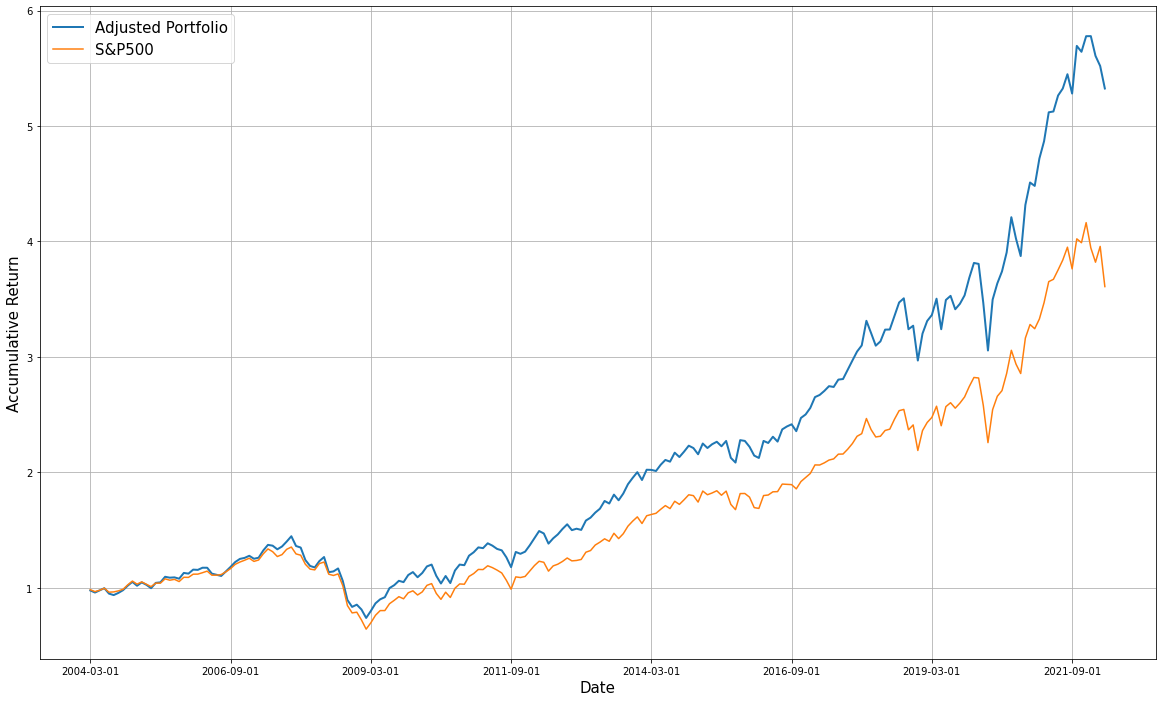

In [100]:
plt.figure(figsize = (20,12))
plt.plot(compare_test0['portAccu'],label = 'Adjusted Portfolio',linewidth = 2)
plt.plot(compare_test0['sp500_Accu'],label = 'S&P500')
plt.xticks(np.arange(0,len(compare_test0),30))
#plt.axvline(x=218, color='g', label='Sample Split',linestyle = '--')
plt.xlabel('Date',fontsize = 15)
plt.ylabel('Accumulative Return',fontsize = 15)
plt.legend(loc = 'upper left',fontsize = 15)
plt.grid()
plt.show()

### Multivariate Regression: Ret ~ Com + CPI + PMI + DXY

In [101]:
df.columns[1:5]
X_col = df.columns[1:5]
y_col = df.columns[5:]
X_train = df_train[X_col]
X_test  = df_test[X_col]

model1      = []
Prediction1 = {}
Result1     = {}

for i in range(len(y_col)):
    y_train = df_train[y_col[i]].to_list()    
    y_test  = df_test[y_col[i]].to_list()
    uni_reg,R2,InPred,Outpred,InRMSE,OutRMSE = Static_Reg(X_train,y_train,X_test,y_test)
    model1.append(uni_reg)
    
    Prediction1[i] = np.concatenate([InPred,Outpred])
    Result1[i]    = [R2,InRMSE,OutRMSE]

In [102]:
for m in range(len(model1)):
    print(y_col[m])
    print(model1[m].summary())
    print('\n')

Materials_ret
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.311
Date:                Sat, 27 Aug 2022   Prob (F-statistic):              0.267
Time:                        00:37:47   Log-Likelihood:                 299.59
No. Observations:                 218   AIC:                            -589.2
Df Residuals:                     213   BIC:                            -572.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.005      

In [103]:
col      = df_select.columns[5:].to_list()
df_pred1 = pd.DataFrame.from_dict(Prediction1)
#df_pred = df_pred[1:].copy()
df_pred1.columns = col
df_pred1.index   = df_select.Date#[1:]

In [104]:
T            = df_pred1.shape[0]
New_weights1 = {}
for i in range(T):
    rank = df_pred1.iloc[i][df_pred1.iloc[i].isna()==False].rank(ascending = False).dropna().to_numpy().astype(int)
    n    = len(rank)
    l    = np.linspace(1/n, -1/n, num=n).round(2)
    weight = l[rank-1] + base_w
    
    New_weights1[i] = weight

In [105]:
port_ret1 = portfolio_ret(df_select.iloc[:,5:],New_weights1)

In [106]:
sp500 = pd.read_csv('/Users/msstark/Desktop/Brandeis/Field Project/data/SP500.csv')
sp500.set_index('Date',inplace=True)
compare1 = sp500[(sp500.index > '1995-02-01') & (sp500.index <'2022-05-01')].copy()
compare1.columns = ['sp500']
compare1.reset_index(inplace = True)

compare1['port']   = pd.Series(port_ret)
compare1.set_index('Date',inplace = True)

compare_test1 = compare1[compare1.index > '2004-02-01'].copy()
compare_test1

,sp500,port
Date,,
2004-03-01,-0.016359,-0.024257
2004-04-01,-0.016791,-0.024703
2004-05-01,0.012083,0.022070
2004-06-01,0.017989,0.023157
2004-07-01,-0.034291,-0.046229
...,...,...
2021-12-01,0.043613,0.037300
2022-01-01,-0.052585,-0.003766
2022-02-01,-0.031360,-0.019043


In [107]:
compare_test1['sp500_Accu'] = (1+compare_test1['sp500']).cumprod()
compare_test1['portAccu'] = (1+compare_test1['port']).cumprod()

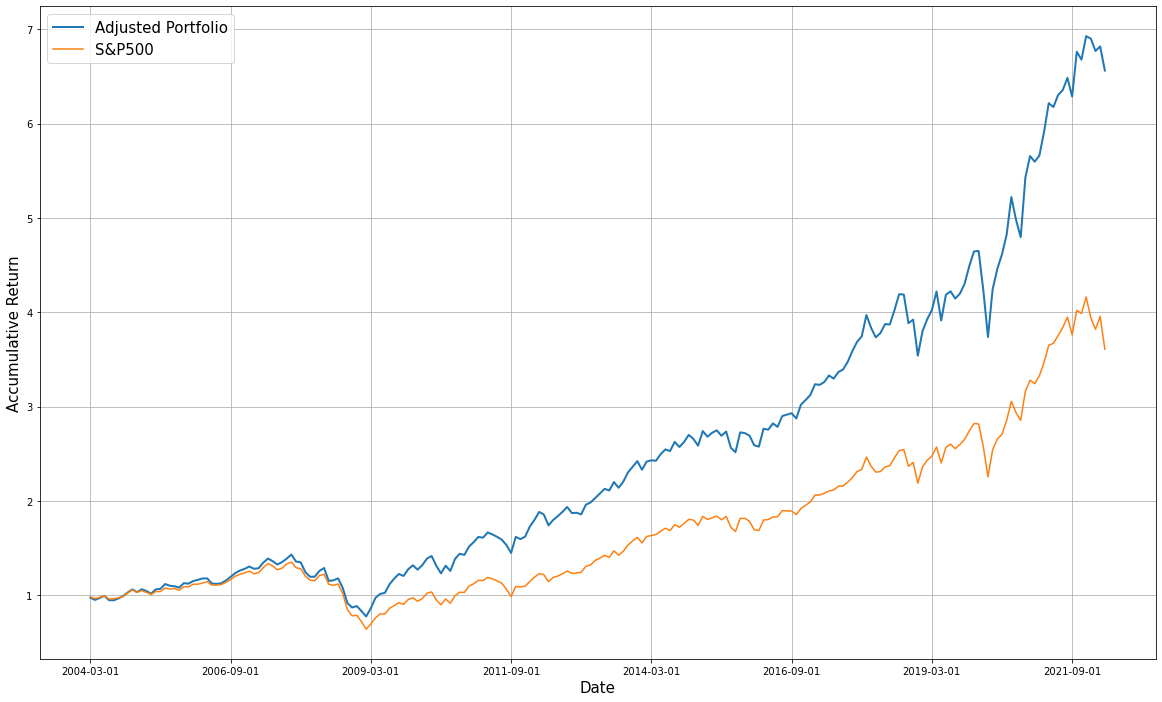

In [108]:
plt.figure(figsize = (20,12))
plt.plot(compare_test1['portAccu'],label = 'Adjusted Portfolio',linewidth = 2)
plt.plot(compare_test1['sp500_Accu'],label = 'S&P500')
plt.xticks(np.arange(0,len(compare_test1),30))
#plt.axvline(x=218, color='g', label='Sample Split',linestyle = '--')
plt.xlabel('Date',fontsize = 15)
plt.ylabel('Accumulative Return',fontsize = 15)
plt.legend(loc = 'upper left',fontsize = 15)
plt.grid()
plt.show()

### Multivariate Regression: Ret ~ Com + CPI + PMI + DXY + Interactions

In [109]:
X_col = df.columns[1:5]
y_col = df.columns[5:]
X_train = df_train[X_col]
X_test  = df_test[X_col]
poly    = PolynomialFeatures(interaction_only=True,include_bias = False)
X_train = poly.fit_transform(X_train)   
X_test  = poly.fit_transform(X_test) 

model2     = []
Prediction2 = {}
Result2    = {}

for i in range(len(y_col)):
    y_train = df_train[y_col[i]].to_list()    
    y_test  = df_test[y_col[i]].to_list()
    uni_reg,R2,InPred,Outpred,InRMSE,OutRMSE = Static_Reg(X_train,y_train,X_test,y_test)
    model2.append(uni_reg)
    
    Prediction2[i] = np.concatenate([InPred,Outpred])
    Result2[i]    = [R2,InRMSE,OutRMSE]

In [110]:
for m in range(len(model2)):
    print(y_col[m])
    print(model2[m].summary())
    print('\n')

Materials_ret
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     1.678
Date:                Sat, 27 Aug 2022   Prob (F-statistic):             0.0877
Time:                        00:39:34   Log-Likelihood:                 305.43
No. Observations:                 218   AIC:                            -588.9
Df Residuals:                     207   BIC:                            -551.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.006      

In [111]:
col      = df_select.columns[5:].to_list()
df_pred2 = pd.DataFrame.from_dict(Prediction2)
#df_pred = df_pred[1:].copy()
df_pred2.columns = col
df_pred2.index   = df_select.Date#[1:]
df_pred2.head()

,Materials_ret,_Industrials_ret,_Consumer_Discretionary_ret,Consumer_Staples_ret,_Health_Care_ret,Financials_ret,Information_Technology_ret,Telecommunication_Services__ret,Utilities_ret,Real_Estate_ret,Energy_ret
Date,,,,,,,,,,,
1995-02-28,-0.002310,-0.000991,0.004695,0.005234,0.006192,-0.006945,0.007700,0.002521,0.008685,-0.011456,0.001421
1995-03-31,0.003016,0.002842,0.011727,0.010764,0.009828,-0.000061,0.008836,0.001559,0.014433,-0.006236,0.003846
1995-04-30,0.014730,0.011595,0.017624,0.013276,0.010495,0.012603,0.010936,0.004654,0.009596,0.013998,0.010446
1995-05-31,-0.012547,-0.001918,0.008118,-0.006034,0.000972,-0.016747,0.017713,0.022625,0.006345,-0.021403,-0.005005
1995-06-30,-0.000129,0.003665,0.004127,0.005349,0.006171,-0.000230,0.005361,0.004812,0.003943,-0.001313,0.009424


In [112]:
T            = df_pred.shape[0]
New_weights2 = {}
for i in range(T):
    rank = df_pred2.iloc[i][df_pred2.iloc[i].isna()==False].rank(ascending = False).dropna().to_numpy().astype(int)
    n    = len(rank)
    l    = np.linspace(1/n, -1/n, num=n).round(2)
    weight = l[rank-1] + base_w
    
    New_weights2[i] = weight

In [113]:
port_ret2 = portfolio_ret(df_select.iloc[:,5:],New_weights2)

In [114]:
sp500 = pd.read_csv('/Users/msstark/Desktop/Brandeis/Field Project/data/SP500.csv')
sp500.set_index('Date',inplace=True)
compare2 = sp500[(sp500.index > '1995-02-01') & (sp500.index <'2022-05-01')].copy()
compare2.columns = ['sp500']
compare2.reset_index(inplace = True)

compare2['port']   = pd.Series(port_ret2)
compare2.set_index('Date',inplace = True)

compare_test2 = compare2[compare2.index > '2004-02-01'].copy()
compare_test2

,sp500,port
Date,,
2004-03-01,-0.016359,-0.023159
2004-04-01,-0.016791,-0.010086
2004-05-01,0.012083,0.015407
2004-06-01,0.017989,0.025763
2004-07-01,-0.034291,-0.048113
...,...,...
2021-12-01,0.043613,0.027586
2022-01-01,-0.052585,-0.016963
2022-02-01,-0.031360,-0.028080


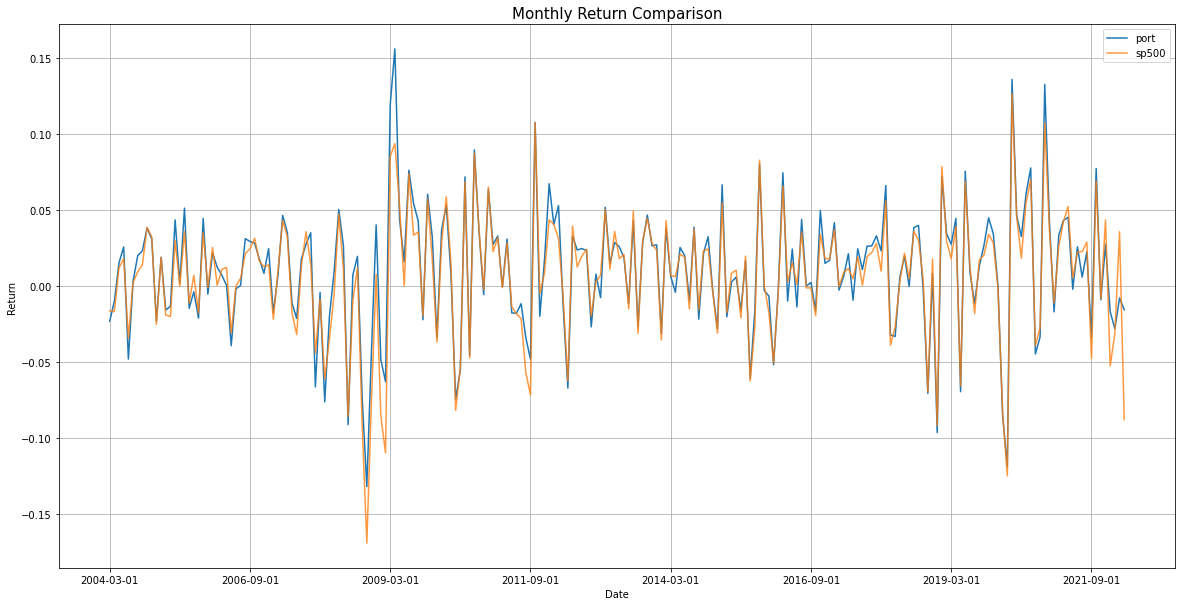

In [115]:
plt.figure(figsize = (20,10))
plt.plot(compare_test2['port'],label = 'port',linewidth = 1.5)    
plt.plot(compare_test2['sp500'],label = 'sp500',linewidth = 1.5,alpha = 0.8)

# setting xtick frequency
plt.xticks(np.arange(0, len(compare_test2)+1, 30),fontsize = 10)
plt.yticks(fontsize = 10)
plt.title('Monthly Return Comparison',fontsize = 15)
# reference line when corr = 0
#plt.axhline(y = 0,color='grey',linestyle='--')
plt.legend(loc = 'upper right',fontsize = 10)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Return',fontsize=10)
plt.grid()

In [116]:
compare_test2['sp500_Accu'] = (1+compare_test2['sp500']).cumprod()
compare_test2['portAccu'] = (1+compare_test2['port']).cumprod()

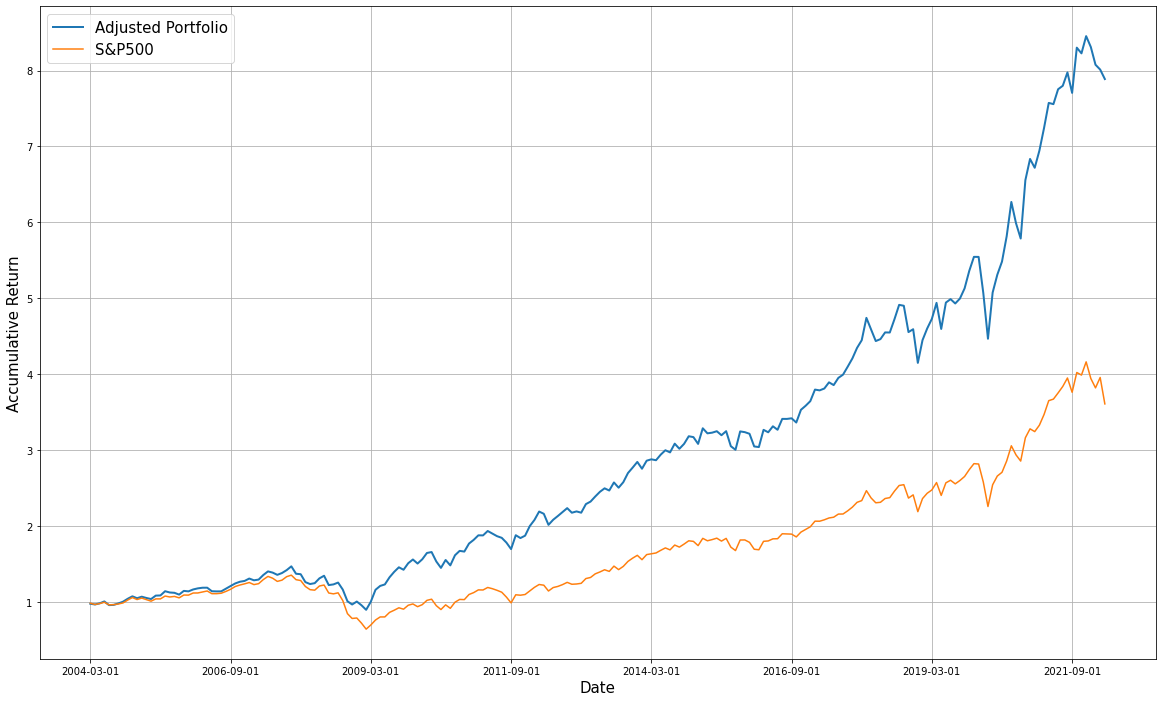

In [117]:
plt.figure(figsize = (20,12))
plt.plot(compare_test2['portAccu'],label = 'Adjusted Portfolio',linewidth = 2)
plt.plot(compare_test2['sp500_Accu'],label = 'S&P500')
plt.xticks(np.arange(0,len(compare_test2),30))
#plt.axvline(x=218, color='g', label='Sample Split',linestyle = '--')
plt.xlabel('Date',fontsize = 15)
plt.ylabel('Accumulative Return',fontsize = 15)
plt.legend(loc = 'upper left',fontsize = 15)
plt.grid()
plt.show()

## Rolling Regression

### Univariate Regression: Ret ~ Com

* Rolling to build dataset

Because we want to use moving forward method to fit our model and making predictions in the next step, so we use the following function to prepare our data.  

In [57]:
# function to construct rolling regression dataset
# four inputs: dataset, 2 column names, 
# 'n_input' represents the forecasting period, 
# 'n_output' represents the number of lag dependent variable need to take
def reg_prep(data,x_name,y_name,n_input,n_output):
    # delete null values
    data     = data[data[y_name].isna()==False].copy()#.reset_index().drop('index',axis = 1)
    in_start = 0
    X, y     = [], []
    for _ in range(len(data)):
        # independent(input) ending point
        in_end  = in_start + n_input - 1.
        # dependent (output) ending point
        out_end = in_end + n_output
        # make sure we have enough data at the end
        if out_end < len(data):
            x_input = data.loc[in_start:in_end, [x_name]].to_numpy()         
            X.append(x_input)
            # in_start+n_output because we need to select the data 1 month later than input 
            # to avoid looking forward bias
            y.append(data.loc[in_start+n_output:out_end, y_name])
        # moving 1 month forward
        in_start += 1
    return X,y

* Fitting and Making Predictions using Moving Forward Method

In [58]:
# function to build regression model and making predictions
def rolling_reg(X,Y):
    R2        = []
    y_predIn  = []
    y_predOut = []
    RMSEIn    = []
    RMSEOut   = []
    # iterate through our prepared dataset fitting the model and making predictions
    for i in range(len(X)):
        x = X[i]
        x = sm.add_constant(x)
        y = Y[i]
        # OLS regression
        uni_reg = sm.OLS(y,x).fit()
        # In sample prediction
        uni_predIn = uni_reg.predict(x[0])
        # Record the SSR for each fitting
        r2_uni = uni_reg.rsquared
        R2.append(r2_uni)
        y_predIn.append(uni_predIn)
        # calculate the In sample Root of mean squared error
        RMSEIn.append(RMSE(y,uni_predIn))    
        # using the next period data as out of sample predictors to make prediction
        # -1 because the last set of data doesn't have a next period
        if i < len(X)-1:
            # Making prediction
            uni_predOut = uni_reg.predict(sm.add_constant(X[i+1])[-1])
            y_predOut.append(uni_predOut[0])
            # Record the out of sample mean squared error
            RMSEOut.append(RMSE(Y[i+1],uni_predOut))  
    return R2, y_predIn, y_predOut, RMSEIn, RMSEOut
    

<b>1. Univariate Regression: SP500 Sector Return ~ BCOM %change</b> 

Forecasting Period = 6

In [59]:
cols    = spret.columns[spret.columns.str.contains('_ret')]
T1      = 6
results = {}
for i in range(len(cols)):
    X_array1,y_array1 = reg_prep(df,'bcom_ret',cols[i],n_input = T1,n_output = 1)
    R2, y_predIn, y_predOut, RMSEIn, RMSEOut = rolling_reg(X_array1,y_array1)
    results[i] = [R2, y_predIn, y_predOut, RMSEIn, RMSEOut]
    print(cols[i])
    print('Mean of R-squared: ',np.mean(R2))
    print('IS RMSE: ',np.mean(RMSEIn))
    print('OOS RMSE: ',np.mean(RMSEOut))
    print('\n')

Materials_ret
Mean of R-squared:  0.21156025232000228
IS RMSE:  0.052705067647601245
OOS RMSE:  0.058410884505567404


_Industrials_ret
Mean of R-squared:  0.17823748447680907
IS RMSE:  0.045540991036291785
OOS RMSE:  0.051210547114672725


_Consumer_Discretionary_ret
Mean of R-squared:  0.20275027976753845
IS RMSE:  0.046047835151454844
OOS RMSE:  0.051517703306032746


Consumer_Staples_ret
Mean of R-squared:  0.20918644531555552
IS RMSE:  0.03372201439066875
OOS RMSE:  0.037411140875626345


_Health_Care_ret
Mean of R-squared:  0.213030025837325
IS RMSE:  0.03979450922857148
OOS RMSE:  0.04439335953408524


Financials_ret
Mean of R-squared:  0.2032560711983284
IS RMSE:  0.052647400567465884
OOS RMSE:  0.05903508388566997


Information_Technology_ret
Mean of R-squared:  0.17296239897605759
IS RMSE:  0.061233376210998364
OOS RMSE:  0.06790458733721141


Telecommunication_Services__ret
Mean of R-squared:  0.1932584097932725
IS RMSE:  0.04999642784624928
OOS RMSE:  0.05594290929303804




Forecasting period = 12

In [60]:
cols     = spret.columns[spret.columns.str.contains('_ret')]
T2       = 12
results2 = {}
for i in range(len(cols)):
    X_array2,y_array2 = reg_prep(df,'bcom_ret',cols[i],n_input = T2,n_output = 1)
    R2, y_predIn, y_predOut, RMSEIn, RMSEOut = rolling_reg(X_array2,y_array2)
    results2[i] = [R2, y_predIn, y_predOut, RMSEIn, RMSEOut]
    print(cols[i])
    print('Mean of R-squared: ',np.mean(R2))
    print('IS RMSE: ',np.mean(RMSEIn))
    print('OOS RMSE: ',np.mean(RMSEOut))
    print('\n')

Materials_ret
Mean of R-squared:  0.09271697056822163
IS RMSE:  0.05532838841317307
OOS RMSE:  0.05657539224574816


_Industrials_ret
Mean of R-squared:  0.075406029411029
IS RMSE:  0.047879718907243705
OOS RMSE:  0.048946876726222575


_Consumer_Discretionary_ret
Mean of R-squared:  0.07391030078091743
IS RMSE:  0.048446002885526175
OOS RMSE:  0.049672612926923


Consumer_Staples_ret
Mean of R-squared:  0.09803313701006584
IS RMSE:  0.03515064301322184
OOS RMSE:  0.03582123375824956


_Health_Care_ret
Mean of R-squared:  0.091090120053676
IS RMSE:  0.04078802162239156
OOS RMSE:  0.041537793475375166


Financials_ret
Mean of R-squared:  0.07763632459992441
IS RMSE:  0.05563968656527888
OOS RMSE:  0.05681710738340252


Information_Technology_ret
Mean of R-squared:  0.06200427214099174
IS RMSE:  0.06342606133868918
OOS RMSE:  0.06532936665629954


Telecommunication_Services__ret
Mean of R-squared:  0.07432824267173839
IS RMSE:  0.05168234078796
OOS RMSE:  0.052915681620525505


Utilities

### Multivariate Regression

* Rolling to build dataset

Compared with the fuction above, the updated function added a new input to control whether we want to add interation variables when doing regression.

In [61]:
def MultiReg_prep(data,x_name,y_name,n_input,n_output,interact):
    data = data[data[y_name].isna()==False].copy().reset_index().drop('index',axis = 1)
    in_start = 0
    X, y     = [], []
    for _ in range(len(data)):
        # independent(input) ending point
        in_end  = in_start + n_input - 1.
        # dependent (output) ending point
        out_end = in_end + n_output
        # make sure we have enough data at the end
        if out_end < len(data):
            x_input = data.loc[in_start:in_end, x_name].to_numpy()
            # add interaction terms if required
            if interact == True:
                # only keep interation terms and delete the bias column (a column of 1)
                poly    = PolynomialFeatures(interaction_only=True,include_bias = False)
                # using this poly feature to fit and transform x
                x_input = poly.fit_transform(x_input)    
            X.append(x_input)
            # in_start+n_output because we need to select the data 1 month later than input 
            # to avoid looking forward bias
            y.append(data.loc[in_start+n_output:out_end, y_name])
        # moving 1 month forward
        in_start += 1
    return X,y

* PCA for dimension reduction

Because now we could add more interaction terms as our independent variables, and because we are making rolling forecast, each time we only use 6 months or 12 months data making forecase, which means that we would have more columns than our rows. For linear regression, that's will be a problem. So, now we are considering use PCA to reduce the dimensionality for our independent variables. 

This find_component funtion is used to find the number of components that can explain certain threshold of variance in our data. In our case, we set the threshold to be 85%.

In [62]:
# function to find the number of component
def find_component(x,threshold):
    # Because PCA is sensitive to variable scale, standardize all the variables before using it
    scaler = StandardScaler()
    pca    = PCA()
    # using pca to reduce the dimension in the predictors
    pca.fit(scaler.fit_transform(x))
    # store the measurement we need to select the number of component as our predictors
    pcaSummary_df = pd.DataFrame({'Standard deviation': np.sqrt(pca.explained_variance_),
                                  'Proportion of variance': pca.explained_variance_ratio_,
                                  'Cumulative proportion': np.cumsum(pca.explained_variance_ratio_)})
    pcaSummary_df.round(4)
    # Cumulative proportion is the percentage of variance can be explained by adding each the component
    # We can set anythreshold as we call the function and select the number of component we need for the
    # regression based on the threshold we set
    ncomponent = pcaSummary_df[pcaSummary_df['Cumulative proportion']<=threshold].index[-1] + 1
    return ncomponent


Compared with the univariate rolling regression function, we add two more inputs to control whether we wannt to use PCA in our regression.

In [63]:
def rolling_MultiReg(X,Y,threshold,regularization):
    R2        = []
    y_predIn  = []
    y_predOut = []
    RMSEIn    = []
    RMSEOut   = []
    # iterate through our prepared dataset fitting the model and making predictions
    for i in range(len(X)):
        x = X[i]
        x = sm.add_constant(x)
        y = Y[i]
        
        # if regularization == False, means we don't want reduce the dimension in our predictors, then
        # the model is just a single linear regression
        if regularization == False:
            model = LinearRegression()  
        # Otherwise, we can use the function above to choose the number of components first
        # Then our model will equal to the pipeline down below, standardize --> PCA --> linear regression 
        else:
            ncomponent = find_component(x,threshold)
            model      = Pipeline([('scaler',StandardScaler()),
                                   ('pca',PCA(n_components = ncomponent)),
                                   ('lr',LinearRegression())])
        # regression
        multi_reg    = model.fit(x,y)
        # In sample prediction
        multi_predIn = multi_reg.predict(x)
        # Record the R2 for each fitting
        r2_multi    = multi_reg.score(x,y)
        R2.append(r2_multi)
        y_predIn.append(multi_predIn[0])
        # calculate the In sample Root of mean squared error
        RMSEIn.append(RMSE(y,multi_predIn))    
        # using the next period data as out of sample predictors to make prediction
        # -1 because the last set of data doesn't have a next period
        if i < len(X)-1:
            # Making predictions
            multi_predOut = multi_reg.predict(sm.add_constant(X[i+1]))
            y_predOut.append(multi_predOut[-1])
            # Record the out of sample mean squared error
            RMSEOut.append(RMSE(Y[i+1],multi_predOut))  
    return R2, y_predIn, y_predOut, RMSEIn, RMSEOut
    

<b>1. Multivariate Regression: SP500 Sector Return ~ BCOM+CPI+PMI+DXY</b>

Forecasting Period: 6 months

In [64]:
cols     = spret.columns[spret.columns.str.contains('_ret')]
ind_cols = ['bcom_ret','cpi_ret','pmi_ret','dxy_ret']
T1       = 6
results7 = {}

for i in range(len(cols)):
    X_array7,y_array7 = MultiReg_prep(df,ind_cols,cols[i],n_input = T1,n_output = 1,interact = False)
    R2, y_predIn, y_predOut, RMSEIn, RMSEOut = rolling_MultiReg(X_array7,y_array7,threshold = 0.86,regularization = False)
    results7[i] = [R2,y_predIn, y_predOut,RMSEIn, RMSEOut]
    
    print(cols[i])
    print('Mean of R-squared: ',np.mean(R2))
    print('IS RMSE: ',np.mean(RMSEIn))
    print('OOS RMSE: ',np.mean(RMSEOut))
    print('\n')

Materials_ret
Mean of R-squared:  0.7953088074442246
IS RMSE:  0.018603561635160082
OOS RMSE:  0.056629348267474434


_Industrials_ret
Mean of R-squared:  0.7772090020910695
IS RMSE:  0.01661001937184938
OOS RMSE:  0.05138412579202889


_Consumer_Discretionary_ret
Mean of R-squared:  0.7910223207870266
IS RMSE:  0.015957552162274253
OOS RMSE:  0.04995596974612456


Consumer_Staples_ret
Mean of R-squared:  0.7633567267277851
IS RMSE:  0.013015280268913918
OOS RMSE:  0.0365434568020311


_Health_Care_ret
Mean of R-squared:  0.7848932838540951
IS RMSE:  0.014534612168062578
OOS RMSE:  0.04110377731684043


Financials_ret
Mean of R-squared:  0.7893187786572677
IS RMSE:  0.018207896184143448
OOS RMSE:  0.05701029158090611


Information_Technology_ret
Mean of R-squared:  0.7881519393437806
IS RMSE:  0.021285835857651297
OOS RMSE:  0.06443078965591158


Telecommunication_Services__ret
Mean of R-squared:  0.7977784110294266
IS RMSE:  0.017731664449978337
OOS RMSE:  0.05460271073990295


Utilit

Forecasting Period: 12 months

In [65]:
cols     = spret.columns[spret.columns.str.contains('_ret')]
ind_cols = ['bcom_ret','cpi_ret','pmi_ret','dxy_ret']
T1       = 12
results8 = {}
for i in range(len(cols)):
    X_array8,y_array8 = MultiReg_prep(df,ind_cols,cols[i],n_input = T1,n_output = 1,interact = False)
    R2, y_predIn, y_predOut, RMSEIn, RMSEOut = rolling_MultiReg(X_array8,y_array8,threshold = 0.86,regularization = False)
    results8[i] = [R2, y_predIn, y_predOut, RMSEIn, RMSEOut]
    print(cols[i])
    print('Mean of R-squared: ',np.mean(R2))
    print('IS RMSE: ',np.mean(RMSEIn))
    print('OOS RMSE: ',np.mean(RMSEOut))
    print('\n')

Materials_ret
Mean of R-squared:  0.34241732262787106
IS RMSE:  0.0426534076829526
OOS RMSE:  0.046778760457135256


_Industrials_ret
Mean of R-squared:  0.29983959856571996
IS RMSE:  0.037879762657313513
OOS RMSE:  0.041444365842130716


_Consumer_Discretionary_ret
Mean of R-squared:  0.314567131046385
IS RMSE:  0.03826823940196628
OOS RMSE:  0.041553199914296006


Consumer_Staples_ret
Mean of R-squared:  0.32578083340223485
IS RMSE:  0.026797831794832548
OOS RMSE:  0.029222971303429518


_Health_Care_ret
Mean of R-squared:  0.3441649652877485
IS RMSE:  0.03088499385973074
OOS RMSE:  0.03345271853891139


Financials_ret
Mean of R-squared:  0.3205334427016611
IS RMSE:  0.042305677280715555
OOS RMSE:  0.046067122466913905


Information_Technology_ret
Mean of R-squared:  0.29716802062178826
IS RMSE:  0.05095817949950048
OOS RMSE:  0.055554322872709165


Telecommunication_Services__ret
Mean of R-squared:  0.31831693971256214
IS RMSE:  0.040683308882922264
OOS RMSE:  0.04446912854904848




<b>2. Multivariate Regression: SP500 Sector Return ~ BCOM+CPI+PMI+DXY+Interactions</b>

Forecasting Period = 6

In [66]:
cols     = spret.columns[spret.columns.str.contains('_ret')]
ind_cols = ['bcom_ret','cpi_ret','pmi_ret','dxy_ret']
T1       = 6
results5 = {}
for i in range(len(cols)):
    X_array5,y_array5 = MultiReg_prep(df,ind_cols,cols[i],n_input = T1,n_output = 1,interact = True)
    R2, y_predIn, y_predOut, RMSEIn, RMSEOut = rolling_MultiReg(X_array5,y_array5,threshold = 0.86,regularization = True)
    results5[i] = [R2, y_predIn, y_predOut, RMSEIn, RMSEOut]
    print(cols[i])
    print('Mean of R-squared: ',np.mean(R2))
    print('IS RMSE: ',np.mean(RMSEIn))
    print('OOS RMSE: ',np.mean(RMSEOut))
    print('\n')

Materials_ret
Mean of R-squared:  0.36777006827139036
IS RMSE:  0.037225106891564094
OOS RMSE:  0.04411041225773271


_Industrials_ret
Mean of R-squared:  0.34710738187675816
IS RMSE:  0.032992334587828194
OOS RMSE:  0.038786879415101616


_Consumer_Discretionary_ret
Mean of R-squared:  0.379736041638804
IS RMSE:  0.032561784894932264
OOS RMSE:  0.038928068557585224


Consumer_Staples_ret
Mean of R-squared:  0.3751649456192746
IS RMSE:  0.023534035314865923
OOS RMSE:  0.02755929376438453


_Health_Care_ret
Mean of R-squared:  0.36794163831197046
IS RMSE:  0.027786590649077677
OOS RMSE:  0.03227109475922864


Financials_ret
Mean of R-squared:  0.36606152163059247
IS RMSE:  0.03752766166823697
OOS RMSE:  0.0445699056650531


Information_Technology_ret
Mean of R-squared:  0.3440793930422016
IS RMSE:  0.04497159733731258
OOS RMSE:  0.05220069614336009


Telecommunication_Services__ret
Mean of R-squared:  0.39265957318545003
IS RMSE:  0.03519366293648812
OOS RMSE:  0.04146428279895395


Uti

Forecasting Period = 12

In [67]:
cols     = spret.columns[spret.columns.str.contains('_ret')]
ind_cols = ['bcom_ret','cpi_ret','pmi_ret','dxy_ret']
T2       = 12
results5 = {}
for i in range(len(cols)):
    X_array5,y_array5 = MultiReg_prep(df,ind_cols,cols[i],n_input = T2,n_output = 1,interact = True)
    R2, y_predIn, y_predOut, RMSEIn, RMSEOut = rolling_MultiReg(X_array5,y_array5,threshold = 0.86,regularization = True)
    results5[i] = [R2, y_predIn, y_predOut, RMSEIn, RMSEOut]
    print(cols[i])
    print('Mean of R-squared: ',np.mean(R2))
    print('IS RMSE: ',np.mean(RMSEIn))
    print('OOS RMSE: ',np.mean(RMSEOut))
    print('\n')

Materials_ret
Mean of R-squared:  0.24248065423384174
IS RMSE:  0.04576718870350515
OOS RMSE:  0.04801358305244416


_Industrials_ret
Mean of R-squared:  0.23284668443222506
IS RMSE:  0.03985987083193872
OOS RMSE:  0.04187205175249224


_Consumer_Discretionary_ret
Mean of R-squared:  0.2580723951293479
IS RMSE:  0.03990532284865571
OOS RMSE:  0.04193566823657433


Consumer_Staples_ret
Mean of R-squared:  0.2908927478933651
IS RMSE:  0.027788291262219548
OOS RMSE:  0.029245624103670362


_Health_Care_ret
Mean of R-squared:  0.28310428983735825
IS RMSE:  0.03238821269163143
OOS RMSE:  0.03387187522507967


Financials_ret
Mean of R-squared:  0.23626888791432787
IS RMSE:  0.045927774710577796
OOS RMSE:  0.04848082396710956


Information_Technology_ret
Mean of R-squared:  0.22496475420583403
IS RMSE:  0.05375109210745937
OOS RMSE:  0.05612638456552784


Telecommunication_Services__ret
Mean of R-squared:  0.27031461602146084
IS RMSE:  0.04245084537722848
OOS RMSE:  0.044644420682773155


Uti